# Figures of merit

In this notebook I will do a bunch of leave-one-out tests using the suite of covariance matrices I have in order to compute the overall figures of merit. Essentially, if the noise on the data comes from a true covariance matrix $\Sigma$, and we have an estimate of that covariance from an emulator $\Sigma_*$, then through the leave-one-out tests we have 25 samples of the changes in any figures of merit.

The quantities that I will look at are the shift in $\chi^2$:
$$
\mathbb{E}(\Delta\chi^2) = \nu - \mathrm{Tr}(\Sigma_*^{-1}\Sigma)\,,
$$
where $\nu=376$ is the length of the data vector, and the covariances are $\nu\times\nu$ in size.
The variance in the shift in $\chi^2$:
$$
\mathrm{Var}(\Delta\chi^2) = 2\nu + 2\mathrm{Tr}(\Sigma_*^{-1}\Sigma\Sigma_*^{-1}\Sigma) - 4\mathrm{Tr}(\Sigma_*^{-1}\Sigma)\,.
$$
And finally the KL divergence:
$$
D_{\rm KL}(P\ ||\ Q) = \frac{1}{2}\left[\mathrm{Tr}(\Sigma_*^{-1}\Sigma) + \ln\det(\Sigma_*\Sigma^{-1}) -\nu \right]\,,
$$
where $P({\bf x}) = \mathcal{N}({\bf x},0,\Sigma)$ and $Q({\bf x}) = \mathcal{N}({\bf x},0,\Sigma_*)$ are Gaussian PDFs with the two different covariance matrices.

In [1]:
#First import everything
import numpy as np
from scipy import stats
import covariance_emulator
import george.kernels as kernels
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", size=28, family="serif")

In [3]:
#Read in the domain locations, or locations in parameter space
parameters = np.loadtxt("cosmo_parameters.txt")
#Load in the covariances
covs = np.load("gaussian_all_covs_withcut.npy")
N = len(covs) #number of cosmologies
Npars = len(parameters[0]) #number of parameters

In [4]:
#Create functions for E(\Delta\chi^2), Var(\Delta\chi^2) and DKL(C_true, C_est)
def expected_chi2_shift(Ctrue, Cest):
    nu = len(Ctrue)
    prod = np.linalg.solve(Cest, Ctrue)
    prod = np.dot(prod, prod)
    return np.trace(prod) - nu

def variance_chi2_shift(Ctrue, Cest):
    nu = len(Ctrue)
    prod = np.linalg.solve(Cest, Ctrue)
    return 2*nu + 2*np.trace(np.dot(prod, prod)) - 4*np.trace(prod)

def KL_divergence(Ctrue, Cest):
    nu = len(Ctrue)
    prod = np.linalg.solve(Cest, Ctrue)
    prod2 = np.linalg.solve(Ctrue, Cest)
    return 0.5 * (np.trace(prod) + np.log(np.linalg.det(prod2)) - nu)

In [5]:
#Define a function to loop over each cosmology, and build an emulator leaving out that
#covariance matrix. Then compute each summary statistic
def get_all_summary_stats(metric_guess = 4., NPC_D = 10, NPC_L = 10):
    #Create arrays to hold each of the summary statistics
    chi2_shift = np.zeros(N)
    chi2_var = np.zeros(N)
    DKL = np.zeros(N)
    for i in range(0, N):
        test_cov = covs[i]
        input_covs = np.delete(covs, i, axis=0)
        test_parameters = parameters[i]
        input_parameters = np.delete(parameters, i, axis=0)
    
        kernel_D = kernels.ExpSquaredKernel(metric=metric_guess, ndim=Npars)
        kernel_L = kernels.ExpSquaredKernel(metric=metric_guess, ndim=Npars)
        Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=NPC_D, NPC_L=NPC_L, 
                                         kernel_D = kernel_D, kernel_lp = kernel_L)
        est_cov = Emu.predict(test_parameters)
    
        chi2_shift[i] = expected_chi2_shift(test_cov, est_cov)
        chi2_var[i] = variance_chi2_shift(test_cov, est_cov)
        DKL[i] = KL_divergence(test_cov, est_cov)
    return chi2_shift, chi2_var, DKL

chi2_shift, chi2_var, DKL = get_all_summary_stats()
print("{0:6.3f} +- {1:5.3f}".format(np.mean(chi2_shift), np.std(chi2_shift)))
print("{0:6.3f} +- {1:5.3f}".format(np.mean(chi2_var), np.std(chi2_var)))
print("{0:6.3f} +- {1:5.3f}".format(np.mean(DKL), np.std(DKL)))

 4.861 +- 2.997
 5.033 +- 3.156
 0.586 +- 0.327


In [6]:
#Record all of these things so that we can make a plot of these statistics as a function 
#of the number of principle components
NPCs = np.arange(5, 20+1)
c2shifts = np.zeros((len(NPCs), N))
c2vars = np.zeros_like(c2shifts)
DKLs = np.zeros_like(c2shifts)

In [7]:
for i, npc in enumerate(NPCs):
    chi2_shift, chi2_var, DKL = get_all_summary_stats(NPC_D = npc, NPC_L = npc)
    c2shifts[i] = chi2_shift
    c2vars[i] = chi2_var
    DKLs[i] = DKL

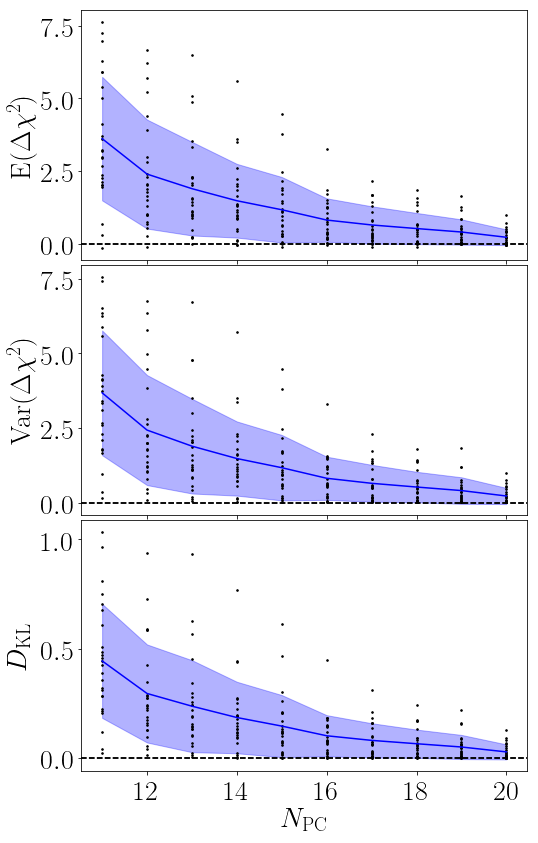

In [8]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(8,14))
plt.subplots_adjust(hspace=0.02)

def add_band(ax, x, cut=6, c='b'):
    ax.plot(NPCs[cut:], np.mean(x[cut:], 1), c=c)
    ax.fill_between(NPCs[cut:], 
                    np.mean(x[cut:], 1) - np.std(x[cut:], 1), 
                    np.mean(x[cut:], 1) + np.std(x[cut:], 1), 
                    color=c, alpha=0.3)
    ax.axhline(0, c='k', ls='--')

def add_scatter(ax, x, cut=6):
    for i, npc in enumerate(NPCs[cut:]):
        ax.scatter(npc*np.ones_like(x[i+cut]), x[i+cut], color='k', marker='.', s=10)
    ax.axhline(0, c='k', ls='--')

cut = 6
add_band(axes[0], c2shifts, cut)
add_band(axes[1], c2vars, cut)
add_band(axes[2], DKLs, cut)
add_scatter(axes[0], c2shifts, cut)
add_scatter(axes[1], c2vars, cut)
add_scatter(axes[2], DKLs, cut)

axes[0].set_ylabel(r"$\mathrm{E}(\Delta\chi^2)$")
axes[1].set_ylabel(r"${\rm Var}(\Delta\chi^2)$")
axes[2].set_ylabel(r"$D_{\rm KL}$")
axes[2].set_xlabel(r"$N_{\rm PC}$")
fig.savefig("figures_of_merit.pdf", bbox_inches="tight")

In [9]:
print("{0:6.3f} +- {0:6.3f}".format(np.mean(c2shifts[-2]), np.std(c2shifts[-2])))
print("{0:6.3f} +- {0:6.3f}".format(np.mean(c2vars[-2]), np.std(c2vars[-2])))
print("{0:6.3f} +- {0:6.3f}".format(np.mean(DKLs[-2]), np.std(DKLs[-2])))

 0.399 +-  0.399
 0.400 +-  0.400
 0.050 +-  0.050
